In [50]:
## Goal of this notebook is to figure out how to create and plots the outlines of the fields that have been plottted



# -- Take a shot at creating a plot of the entire fields.
# - take the kml file. create the centroid
# 	- create a merged polygon with complete outline of field
# 	- measure distance from centroid to the polygons (use 540 measurements for the outfield in current code. That would scale up to 2160 measurements.



## Dependencies and Setup
### Dependencies

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import time
import matplotlib.pyplot as plt


In [51]:
### Going to bring the code in to start with a kml file and transform it into 
### a polygon that can be plotted.

## Open KML
## LOAD BLOCK###
#### Load data from kml file exported from Google Earth

file_path = ('TEMP/clean_tables/geo_data/all_high_schools.kml') # file path to kml file


# Read the KML file
with open(file_path) as file:
    xml_data = file.read()

# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')

# Create a list to store rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text
        notes = None

        # Check if there is a description tag, if so, use it for notes
        if folder.find('description') is not None:
            notes = folder.find('description').text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop,
            'notes': notes
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows, columns=['field', 'foul', 'fop', 'notes'])



In [52]:
# Clean the new dataframe


# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

##### Clean up polygon data and create a new home_plate column

def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])

# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)


############## AREA CALCULATION ##############


import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform


def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Create a custom LAEA projection centered on the centroid
    custom_projection = f"+proj=laea +lat_0={centroid.y} +lon_0={centroid.x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

    # Create a transformer for converting coordinates to the custom LAEA projection
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(custom_projection),  # Custom LAEA projection
        always_xy=True
    )

    # Define a function to transform coordinates using the transformer
    def transform_coordinates(x, y):
        return transformer.transform(x, y)

    # Convert the coordinates to the custom LAEA projection
    polygon_laea = transform(transform_coordinates, polygon)

    # Calculate the area in square meters
    area_sqm = polygon_laea.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft



### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)

## Calculate the total area of the field and the ratio of foul area to field area
df_cleaned['field_area_sqft'] = df_cleaned['foul_area_sqft'] + df_cleaned['fop_area_sqft']
## Percentage foul area
df_cleaned['foul_area_per'] = df_cleaned['foul_area_sqft'] / df_cleaned['field_area_sqft']
## Fair to Foul Ratio
df_cleaned['fair_to_foul'] = df_cleaned['fop_area_sqft'] / df_cleaned['foul_area_sqft']




In [53]:
#### Orienting the map to the home plate location ####

### Find the center of the field
def calculate_centroid(coords):
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    centroid_x = sum(x_coords) / len(coords)
    centroid_y = sum(y_coords) / len(coords)
    return (centroid_x, centroid_y)


## Find the bearing between the home plate and the center of the field
import math

def calculate_bearing(point1, point2):
    lat1, lon1 = math.radians(point1[1]), math.radians(point1[0])
    lat2, lon2 = math.radians(point2[1]), math.radians(point2[0])

    d_lon = lon2 - lon1

    x = math.cos(lat2) * math.sin(d_lon)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)

    bearing = math.degrees(math.atan2(x, y))
    bearing = (bearing + 360) % 360  # Normalize the bearing to the range [0, 360)

    return bearing

### Function to classify direction in laymans terms North, South, East, West, ect
def degrees_to_cardinal_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    index = round(degrees / 45)
    return directions[index]

In [54]:
# Calculate the centroid of the outfield fence coordinates for each row
df_cleaned['fop_centroid'] = df_cleaned['fop'].apply(lambda coords: calculate_centroid(coords[1:]))

# Calculate the bearing between home plate and the centroid for each row
df_cleaned['field_orientation'] = df_cleaned.apply(lambda row: calculate_bearing(row['home_plate'], row['fop_centroid']), axis=1)

# Convert the bearing to a cardinal direction
df_cleaned['field_cardinal_direction'] = df_cleaned['field_orientation'].apply(degrees_to_cardinal_direction)

# rename 'field' to 'park_name'
df_cleaned.rename(columns={'field': 'park_name'}, inplace=True)




In [55]:
## print one record from the fop column
print(df_cleaned['fop'][10])

[(-84.6479335, 43.3931241), (-84.6491713, 43.3931046), (-84.6491726, 43.3930539), (-84.649174, 43.3929964), (-84.649178, 43.392938), (-84.649174, 43.3928532), (-84.6491713, 43.3927879), (-84.6491686, 43.3927333), (-84.6491498, 43.3926671), (-84.6491217, 43.3926164), (-84.6490855, 43.3925618), (-84.6490399, 43.3925063), (-84.6489889, 43.3924536), (-84.6489366, 43.3924186), (-84.648891, 43.3923825), (-84.6488172, 43.3923338), (-84.6487314, 43.3922997), (-84.6486617, 43.3922685), (-84.648604, 43.3922519), (-84.6485329, 43.3922353), (-84.6484766, 43.3922334), (-84.6483948, 43.3922285), (-84.6482969, 43.3922275), (-84.6481816, 43.3922285), (-84.6480542, 43.3922285), (-84.6478812, 43.3922266), (-84.6479335, 43.3931241)]


In [56]:
### Create the merged polygon from the foul and fop coordinates
## Save the merged polygon into a new column called 'full_polygon'

from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union

# Assuming df_cleaned is your dataframe, and 'fop' and 'foul' are your columns

# Convert list of coordinate tuples to Shapely Polygon objects
df_cleaned['fop'] = df_cleaned['fop'].apply(lambda x: Polygon(x))
df_cleaned['foul'] = df_cleaned['foul'].apply(lambda x: Polygon(x))

# Function to merge polygons
def merge_polygons(row):
    return unary_union([row['fop'], row['foul']])

# Create new column with merged polygons
df_cleaned['merged'] = df_cleaned.apply(merge_polygons, axis=1)



c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [57]:
df_cleaned.sample(5)

,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,fop_centroid,field_orientation,field_cardinal_direction,merged
231,Howell High School,"POLYGON ((-83.9426426 42.6179456, -83.9426802 ...","POLYGON ((-83.9426426 42.6179456, -83.9414772 ...",None,"(-83.9426426, 42.6179456)",21102.005381,92919.160467,114021.165848,0.185071,4.403333,"(-83.94187007812498, 42.618537471874994)",43.845084,NE,"POLYGON ((-83.941491 42.6179319, -83.9424164 4..."
336,Muskegon Western Michigan Christian HS,"POLYGON ((-86.2367956 43.1609022, -86.236754 4...","POLYGON ((-86.2367956 43.1609022, -86.2356235 ...",None,"(-86.2367956, 43.1609022)",28662.155920,91282.061102,119944.217022,0.238962,3.184759,"(-86.23598504615383, 43.161468603846146)",46.228958,NE,"POLYGON ((-86.2356302 43.1608239, -86.2356382 ..."
320,Millington HS,"POLYGON ((-83.5209755 43.2748751, -83.5214636 ...","POLYGON ((-83.5209755 43.2748751, -83.5198959 ...",None,"(-83.5209755, 43.2748751)",28123.354668,93372.636358,121495.991026,0.231476,3.320110,"(-83.52052451290324, 43.27564667096774)",23.052502,NE,"POLYGON ((-83.5198851 43.2752285, -83.519865 4..."
396,Reed City HS,"POLYGON ((-85.514191 43.8677766, -85.5131275 4...","POLYGON ((-85.514191 43.8677766, -85.5142124 4...",None,"(-85.514191, 43.8677766)",20204.536996,67773.764592,87978.301588,0.229654,3.354383,"(-85.513489688, 43.867293744)",133.681262,SE,"POLYGON ((-85.5131409 43.8677022, -85.513161 4..."
484,Watervliet HS,"POLYGON ((-86.2497962 42.1861372, -86.2501248 ...","POLYGON ((-86.2497962 42.1861372, -86.248671 4...",None,"(-86.2497962, 42.1861372)",29957.079671,90697.021867,120654.101537,0.248289,3.027566,"(-86.2492441, 42.18683773888889)",30.282972,NE,"POLYGON ((-86.2486603 42.1863479, -86.2494328 ..."


In [58]:
############# FENCE DISTANCE CALCULATION #############

from geopy.distance import great_circle
import numpy as np
from shapely.geometry import MultiPolygon





def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, coords, num_points=2160):
    distances = []

    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance
    
    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(coords) - 1):
        start = coords[i]
        end = coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = great_circle(home_plate_lat_lon, (point[1], point[0])).feet
        distances.append(distance)

        current_length += spacing

    return distances




df_cleaned['distances'] = df_cleaned.apply(
    lambda row: calculate_distances(
        row['home_plate'], 
        row['merged'].exterior.coords[:]
    ) if not isinstance(row['merged'], MultiPolygon) else np.nan, 
    axis=1
)




# # Calculate max, min, and average distances for each row
# df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
# df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
# df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))
# # get the median distance
# df_cleaned['median_distance'] = df_cleaned['distances'].apply(lambda distances: np.median(distances))


In [59]:
## Show the resulting dataframe

df_cleaned.head(10)

,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,fop_centroid,field_orientation,field_cardinal_direction,merged,distances
0,Ann Arbor Greenhills HS? - Practice?,POLYGON ((-84.01481943219841 41.86694040616026...,POLYGON ((-84.01374704390223 41.86720354412398...,None,"(-84.01374704390223, 41.86720354412398)",38841.574963,81549.188789,120390.763752,0.322629,2.099534,"(-84.01441536073496, 41.86766324525184)",312.727969,NW,"POLYGON ((-84.0137448218278 41.86719325061626,...","[3.8034219134006806, 4.409812293373844, 5.0162..."
1,Adams Butzel Complex - Detroit Communication M...,"POLYGON ((-83.1678186 42.3966942, -83.1678776 ...","POLYGON ((-83.1678186 42.3966942, -83.1665385 ...",None,"(-83.1678186, 42.3966942)",43132.874486,94900.435141,138033.309627,0.312482,2.200188,"(-83.16713494545455, 42.39733947575757)",38.039869,NE,"POLYGON ((-83.1665378 42.3966962, -83.1665405 ...","[345.0642932282179, 345.0156068055157, 344.968..."
2,Addison HS,"POLYGON ((-84.3395166 41.9898236, -84.3406566 ...","POLYGON ((-84.3395166 41.9898236, -84.3394898 ...",None,"(-84.3395166, 41.9898236)",30054.010276,81120.874515,111174.884791,0.270331,2.699170,"(-84.34025218333335, 41.990368462499994)",314.902223,NW,"POLYGON ((-84.3393222 41.9906699, -84.3393423 ...","[313.2089008563649, 312.6177712123428, 312.026..."
3,Adrian HS,"POLYGON ((-84.0416584 41.9091676, -84.0416691 ...","POLYGON ((-84.0416584 41.9091676, -84.0405493 ...",None,"(-84.0416584, 41.9091676)",36619.533089,86478.745151,123098.278240,0.297482,2.361547,"(-84.04087369166668, 41.909742770833326)",45.435207,NE,"POLYGON ((-84.0405547 41.9091536, -84.0408055 ...","[299.6934050349349, 299.18213548818505, 298.67..."
4,Adrian Lenawee Christian HS,"POLYGON ((-84.0837469 41.9087669, -84.0841117 ...","POLYGON ((-84.0837469 41.9087669, -84.0826392 ...",None,"(-84.0837469, 41.9087669)",23307.977485,89142.387688,112450.365172,0.207273,3.824544,"(-84.08335302608694, 41.909511691304346)",21.482674,N,"POLYGON ((-84.0826338 41.9090105, -84.0827143 ...","[314.9990541250067, 314.5346744463308, 314.070..."
5,Alcona HS,"POLYGON ((-83.4068606 44.6597432, -83.4080341 ...","POLYGON ((-83.4068606 44.6597432, -83.4068016 ...",tough treeline in center and left,"(-83.4068606, 44.6597432)",22722.351670,83689.915400,106412.267070,0.213531,3.683154,"(-83.40761245652176, 44.66032349565217)",317.337265,NW,"POLYGON ((-83.4067077 44.6604491, -83.4067198 ...","[260.5601223818863, 259.9882991160879, 259.416..."
6,Algonac High School,"POLYGON ((-82.5823976 42.6286202, -82.5813154 ...","POLYGON ((-82.5823976 42.6286202, -82.5826256 ...",None,"(-82.5823976, 42.6286202)",30409.852869,83315.423957,113725.276826,0.267397,2.739751,"(-82.58202652142857, 42.62790593571429)",159.080631,S,"POLYGON ((-82.5814521 42.6279985, -82.5815192 ...","[340.3648333766891, 340.6302931696074, 340.896..."
7,Allegan HS,"POLYGON ((-85.8755219 42.5312676, -85.8754455 ...","POLYGON ((-85.8755219 42.5312676, -85.8765814 ...",None,"(-85.8755219, 42.5312676)",35265.755123,82903.009176,118168.764299,0.298436,2.350808,"(-85.87616103478261, 42.53063376956522)",216.615492,SW,"POLYGON ((-85.8755487 42.5304098, -85.8756453 ...","[313.01974800021117, 313.0690377747515, 313.11..."
8,Allen Park High School,"POLYGON ((-83.2273711 42.2455509, -83.2285244 ...","POLYGON ((-83.2273711 42.2455509, -83.2273992 ...",None,"(-83.2273711, 42.2455509)",21918.951539,94593.687506,116512.639046,0.188125,4.315612,"(-83.22816921944445, 42.24611941944444)",313.898215,NW,"POLYGON ((-83.2273603 42.2464087, -83.2273174 ...","[312.9504117739645, 312.7299950094142, 312.510..."
9,Allendale HS,"POLYGON ((-85.9477745 42.9641256, -85.9478134 ...","POLYGON ((-85.9477745 42.9641256, -85.9466198 ...",None,"(-85.9477745, 42.9641256)",21522.841094,88971.959043,110494.800137,0.194786,4.133839,"(-85.94700725652176, 42.96473563043479)",42.625141,NE,"POLYGON ((-85.9466198 42.9641148, -85.9472716 ...","[308.2876839880368, 307.7142055535995, 307.140..."

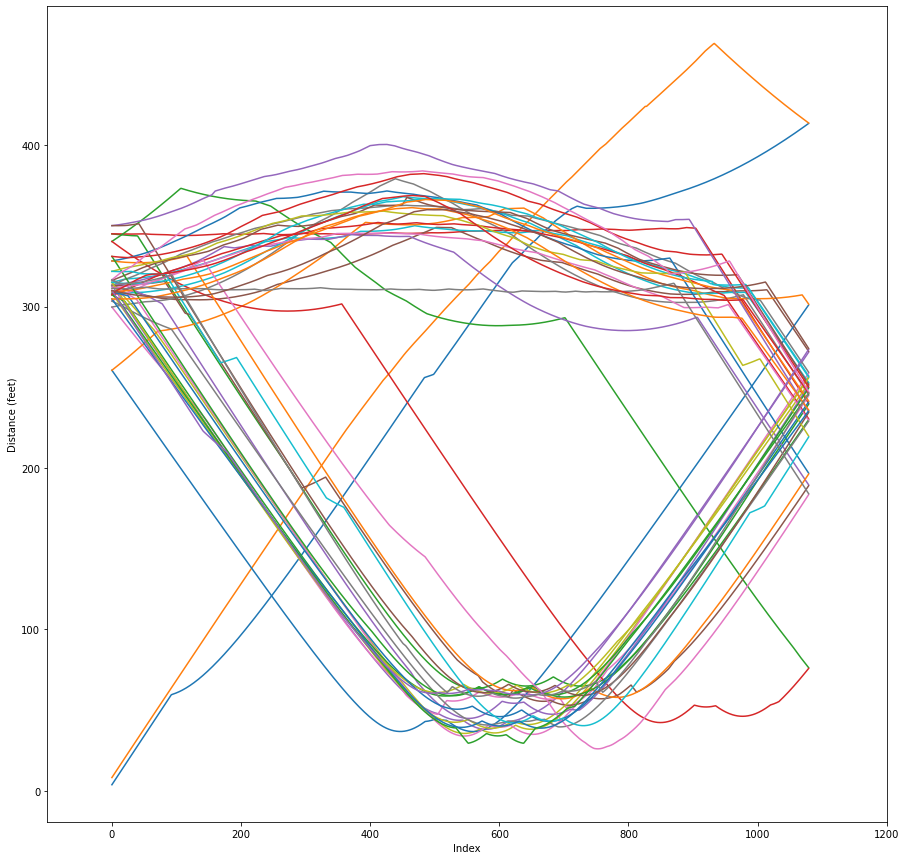

In [60]:
import matplotlib.pyplot as plt

# Plot the distances and their mirrored version for the first 5 rows
for i in range(25):
    try:
        distances = df_cleaned['distances'][i]
        half = len(distances) // 2  # Find the middle index
        distances_half_1 = distances[:half]  # First half of the distances
        distances_half_2 = distances[half:][::-1]  # Second half of the distances, reversed
        
        plt.plot([i for i in range(half)], distances_half_1, label=df_cleaned['park_name'][i] + '_1')
        plt.plot([i for i in range(half)], distances_half_2, label=df_cleaned['park_name'][i] + '_2')
    except Exception as e:
        pass


# set the size of the plot
plt.rcParams["figure.figsize"] = (20,15)
plt.xlim(-100, 1200)

# Set the image resolution
plt.rcParams['figure.dpi'] = 600

ax = plt.gca()
ax.set_aspect(2.5)

plt.xlabel("Index")
plt.ylabel("Distance (feet)")


# plt.legend()
plt.show()


In [61]:
### make a plot of a couple of the fences using the distance column

import matplotlib.pyplot as plt

# Plot the distances for the first 5 rows
for i in range(5):
    plt.plot(df_cleaned['distances'][i])
plt.show()


In [62]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# def plot_field(df):
#     # generate an array of angles for plotting
#     angles = np.linspace(0, 2 * np.pi, 2160, endpoint=False)

#     for idx, row in df.iterrows():
#         # adjusting the angles based on field orientation
#         adjusted_angles = (angles + np.deg2rad(row['field_orientation'])) % (2*np.pi)
        
#         # convert polar coordinates to cartesian coordinates
#         x = row['fop_centroid'][0] + np.array(row['distances']) * np.cos(adjusted_angles)
#         y = row['fop_centroid'][1] + np.array(row['distances']) * np.sin(adjusted_angles)
        
#         plt.figure()
#         plt.plot(x, y)
#         plt.title(row['park_name'])
#         plt.xlabel("Feet")
#         plt.ylabel("Feet")
#         plt.gca().set_aspect('equal', adjustable='box')
#         plt.show()

# # Let's assume you have a DataFrame df
# # df = pd.read_csv('your_data.csv')  # replace with your actual data file
# plot_field(df_cleaned)
